### Load your Libraries

In [ ]:
!pip install xgboost==0.90
!pip install tensorflow
!pip install -q git+https://github.com/tensorflow/docs

In [22]:
# Common Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import math
import datetime as dt
import os
import logging
from dateutil.relativedelta import relativedelta
from operator import attrgetter
from datetime import datetime

In [23]:
# Azure Libaries
from azureml.core import Datastore
from azureml.core.dataset import Dataset
from azureml.core.workspace import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication

In [24]:
# XG Boost Libraries # CHANGE HERE TO MATCH YOUR ALGORITHM
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pylab as plt
from matplotlib import pyplot
from collections import Counter

In [25]:
# Tensorflow liba
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)


2.1.0


In [26]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'  # to allow the program to continue to execute in case multiple conflicting libs are attached to a program - not safe
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder

### Set Your Workspace

In [27]:
# Check the base version of AzureMl
import azureml.core
print("You are currently using version " + azureml.core.VERSION + " of the Azure ML SDK")

You are currently using version 1.6.0 of the Azure ML SDK


In [28]:
# Retrieve your workspace
ws = Workspace.from_config()

### Set your Datasets

In [29]:
# Retrieve your Datasets by name
df_name  = "auto-mpg-classification-input" # CHANGE HERE


# Load Data in as Tabular Datasets
df_tab  = Dataset.get_by_name(ws, df_name, version='latest')


# Change to pandas dataframe
df = df_tab.to_pandas_dataframe()


In [30]:
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,18.0,8,307.0,130,3504,12.0,70,1,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,1,"\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,1,"\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,1,"\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,1,"\t""ford torino"""


In [31]:
# get rid of the last column as we dont gain any info from it
df_column9_dropped = df.drop(['Column9'], axis=1)
df_column9_dropped.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [32]:
# add header row to the dataframe
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
df_column9_dropped.columns = column_names
df_with_headers = df_column9_dropped
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [33]:
# remove rows with '?' character

df_with_headers = df_with_headers[df_with_headers.Horsepower != '?']
df_with_headers.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


### Prepare Modeling Data

### The "Origin" column is really categorical, not numeric. So convert that to a one-hot:



In [34]:
df_with_headers['Origin'] = df_with_headers['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

df_with_headers.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130,3504,12.0,70,USA
1,15.0,8,350.0,165,3693,11.5,70,USA
2,18.0,8,318.0,150,3436,11.0,70,USA
3,16.0,8,304.0,150,3433,12.0,70,USA
4,17.0,8,302.0,140,3449,10.5,70,USA


In [35]:
# generate binary values using get_dummies

# you can use pandas get_dummies to convert categorical variable into dummy/indicator variables.
# or use sklean OneHotEncoder
encoded_df = pd.get_dummies(df_with_headers, columns=["Origin"], prefix=["Origin_is"] )

encoded_df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
0,18.0,8,307.0,130,3504,12.0,70,0,0,1
1,15.0,8,350.0,165,3693,11.5,70,0,0,1
2,18.0,8,318.0,150,3436,11.0,70,0,0,1
3,16.0,8,304.0,150,3433,12.0,70,0,0,1
4,17.0,8,302.0,140,3449,10.5,70,0,0,1


### Split the data into train and test

In [36]:
train_dataset = encoded_df.sample(frac=0.8,random_state=0)
test_dataset = encoded_df.drop(train_dataset.index)

### Inspect the data 


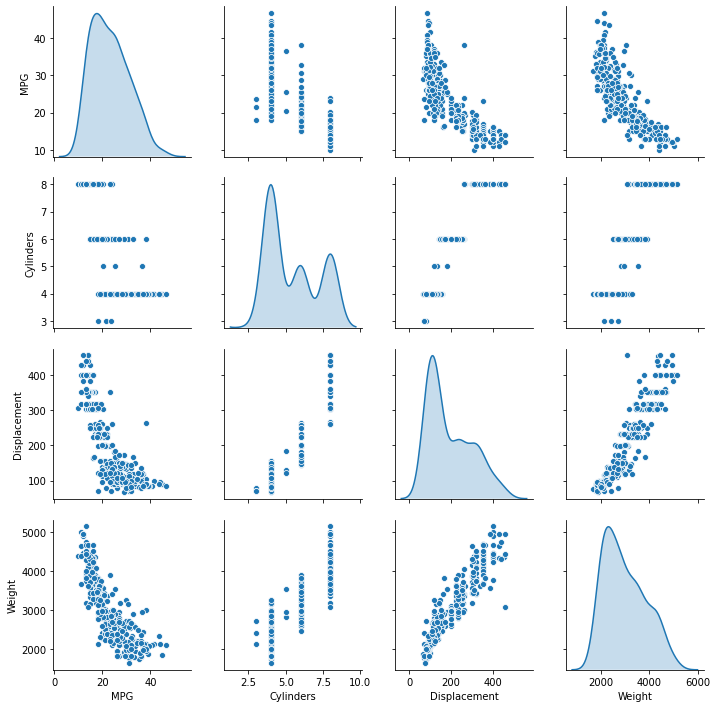

In [37]:
#Have a quick look at the joint distribution of a few pairs of columns from the training set.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")



In [38]:
#Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.0,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.5,151.0,265.75,455.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.5,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.8,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.0,76.0,79.00,82.0
Origin_is_Europe,314.0,0.178344,0.383413,0.0,0.0,0.0,0.00,1.0
Origin_is_Japan,314.0,0.197452,0.398712,0.0,0.0,0.0,0.00,1.0
Origin_is_USA,314.0,0.624204,0.485101,0.0,0.0,1.0,1.00,1.0


### Separate the features from the target variable(mpg)

In [39]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the dataset

In [40]:
#"The goal of normalization is to change the values of numeric columns in the dataset to a common scale"
#"Among the best practices for training a Neural Network is to normalize your data to obtain a mean close to 0."
#"Normalizing the data generally speeds up learning and leads to faster convergence.""

# "MinMaxScaler: For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then 
# divides bytrain_dataset the range. The range is the difference between the original maximum and original minimum. 
# MinMaxScaler preserves the shape of the original distribution"


min_max_scaler = preprocessing.MinMaxScaler()


train_dataset[list(train_dataset.columns)] = min_max_scaler.fit_transform(train_dataset[list(train_dataset.columns)])
    



/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [41]:
train_dataset.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_is_Europe,Origin_is_Japan,Origin_is_USA
146,0.2,0.056848,0.162011,0.136351,0.386905,0.333333,0.0,0.0,1.0
282,0.2,0.186047,0.234637,0.355486,0.553571,0.750000,0.0,0.0,1.0
69,1.0,0.728682,0.636872,0.804068,0.327381,0.166667,0.0,0.0,1.0
378,0.2,0.095607,0.094972,0.136351,0.398810,1.000000,0.0,0.0,1.0
331,0.2,0.074935,0.117318,0.142080,0.595238,0.833333,0.0,1.0,0.0


### Build NN for regression using TF

In [42]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
# Rmsprop is a gradient-based optimization technique to minimize the loss function
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [43]:
model = build_model()

### Inspect the model

In [44]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [45]:
# Train the model for 1000 epochs (number of times feeding the training set to the network for learning), 
# and record the training and validation accuracy in the history object.

epochs= 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0, # verbose indicates the level of training progress displayedfor each epoch.
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:582.0133,  mae:22.8451,  mse:582.0132,  val_loss:589.8982,  val_mae:22.9701,  val_mse:589.8983,  
....................................................................................................
Epoch: 100, loss:8.4645,  mae:2.0592,  mse:8.4645,  val_loss:7.8665,  val_mae:2.1291,  val_mse:7.8665,  
....................................................................................................
Epoch: 200, loss:7.2328,  mae:1.8867,  mse:7.2328,  val_loss:7.8142,  val_mae:2.0756,  val_mse:7.8142,  
....................................................................................................
Epoch: 300, loss:6.8555,  mae:1.8776,  mse:6.8555,  val_loss:7.6942,  val_mae:2.0564,  val_mse:7.6942,  
....................................................................................................
Epoch: 400, loss:6.6020,  mae:1.8197,  mse:6.6020,  val_loss:7.3317,  val_mae:2.0200,  val_mse:7.3317,  
..............................................................

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,5.071435,1.545411,5.071435,7.295566,2.089936,7.295566,995
996,4.930163,1.511694,4.930164,7.059730,2.008103,7.059730,996
997,4.993167,1.533735,4.993166,6.888226,1.955777,6.888226,997
998,5.198653,1.539724,5.198653,6.883317,1.968825,6.883317,998
999,5.103269,1.506673,5.103269,6.905460,1.963147,6.905460,999


Text(0, 0.5, 'MAE [MPG]')

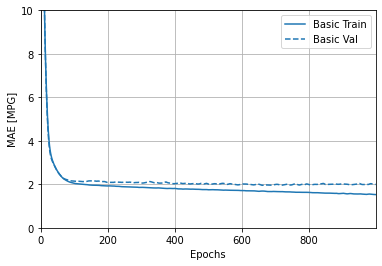

In [47]:
# refer to https://github.com/tensorflow/docs for APIs
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')



Text(0, 0.5, 'MSE [MPG^2]')

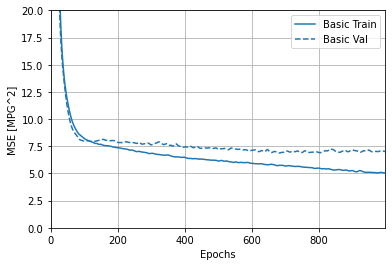

In [48]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [49]:
model = build_model()

# patience: Number of epochs with no improvement after which training will be stopped.
# The patience parameter is the amount of epochs to check for improvement
# min_delta: Minimum change in the monitored quantity to qualify as an improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_dataset, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:576.6125,  mae:22.7092,  mse:576.6125,  val_loss:581.9563,  val_mae:22.7429,  val_mse:581.9563,  
....................................................................................................
Epoch: 100, loss:8.0977,  mae:2.0389,  mse:8.0977,  val_loss:7.9798,  val_mae:2.1502,  val_mse:7.9798,  
................................

Text(0, 0.5, 'MAE [MPG]')

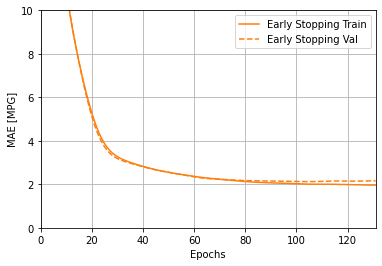

In [50]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

### Make predictions on test dataset

In [51]:
# make sure to normalize test dataset before running prediction on it

test_dataset = min_max_scaler.transform(test_dataset)


loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


78/78 - 0s - loss: 6.1993 - mae: 1.9764 - mse: 6.1993
Testing set Mean Abs Error:  1.98 MPG


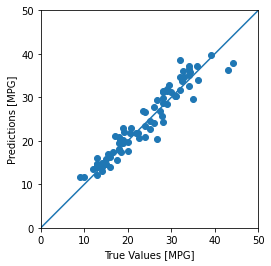

In [57]:
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

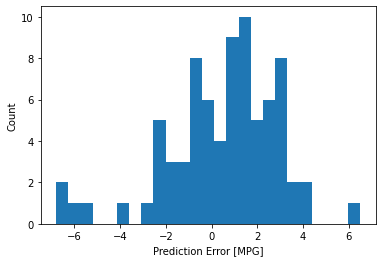

In [53]:
# error distribution

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")